In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline



data = pd.read_csv('winequality-red.csv', delimiter=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


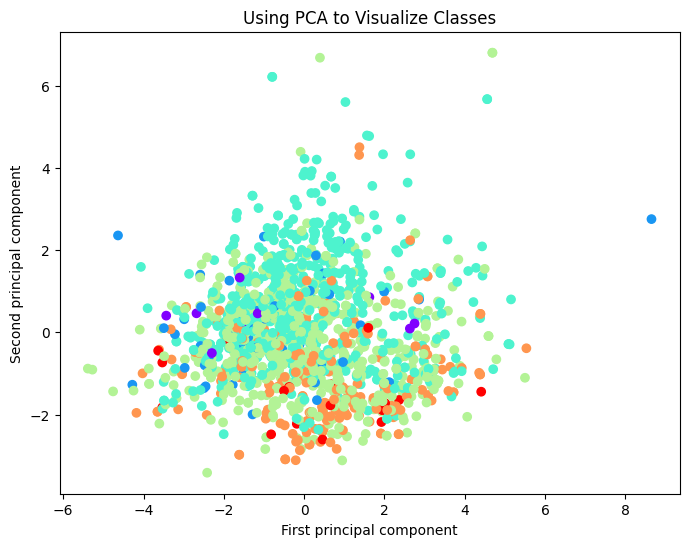

In [17]:
df_pca = data.copy()
X_pca = df_pca.drop('quality',axis=1)
y_pca = df_pca['quality']

X_pca.tail()
X_pca = StandardScaler().fit_transform(X_pca)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)
X_pca.shape

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_pca,cmap='rainbow')
plt.title('Using PCA to Visualize Classes')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

In [18]:
print("PCA Components:\n ", pca.components_)
print("PCA Explained Variance Ratio:\n ", pca.explained_variance_ratio_)
print("PCA Explained Variance:\n ", pca.explained_variance_)

PCA Components:
  [[ 0.48931422 -0.23858436  0.46363166  0.14610715  0.21224658 -0.03615752
   0.02357485  0.39535301 -0.43851962  0.24292133 -0.11323206]
 [-0.11050274  0.27493048 -0.15179136  0.27208024  0.14805156  0.51356681
   0.56948696  0.23357549  0.00671079 -0.03755392 -0.38618096]]
PCA Explained Variance Ratio:
  [0.28173931 0.1750827 ]
PCA Explained Variance:
  [3.10107182 1.92711489]


In [19]:
X_f = data.loc[:, 'fixed acidity':'alcohol']
y_f = data['quality']

#apply SelectKBest class to extract top best features
bestFeatures = SelectKBest(score_func=chi2, k=11)
bestFeaturesFit = bestFeatures.fit(X_f,y_f)
dfscores = pd.DataFrame(bestFeaturesFit.scores_)  #Store predictor scores in a column 
dfcolumns = pd.DataFrame(X_f.columns)  #Store predictor variable names in a column

# #concatenate scores with predictor names
predScores = pd.concat([dfcolumns,dfscores],axis=1)
predScores.columns = ['Predictor','Score']   #naming the dataframe columns
print(predScores.nlargest(11,'Score'))       #print top (by score) 10 features

               Predictor        Score
6   total sulfur dioxide  2755.557984
5    free sulfur dioxide   161.936036
10               alcohol    46.429892
1       volatile acidity    15.580289
2            citric acid    13.025665
0          fixed acidity    11.260652
9              sulphates     4.558488
3         residual sugar     4.123295
4              chlorides     0.752426
8                     pH     0.154655
7                density     0.000230


In [20]:
#Drop the bottom two features (smallest score)
data = data.drop('density', axis=1)
data = data.drop('pH', axis=1)

# Select data (ignore certain features)
X = data.loc[:, 'fixed acidity':'alcohol']
y = data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=420)


In [21]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Random Forest Parameters: ", best_rf)

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("=====================RANDOM FOREST CLASSIFIER=====================\n")
print("Accuracy: ", accuracy)
print('\nClassification Report: \n', report)

Best Random Forest Parameters:  RandomForestClassifier(max_depth=15, n_estimators=300)
=====================RANDOM FOREST CLASSIFIER=====================

Accuracy:  0.7104166666666667

Classification Report: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         9
           5       0.78      0.80      0.79       203
           6       0.66      0.74      0.70       197
           7       0.66      0.55      0.60        60
           8       0.00      0.00      0.00        10

    accuracy                           0.71       480
   macro avg       0.35      0.35      0.35       480
weighted avg       0.68      0.71      0.69       480



c:\Users\emily\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\emily\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\emily\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

c:\Users\emily\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best number of hidden nodes: 35, with a test accuracy of 0.6354166666666666
Non normalized test accuracy of 0.43333333333333335


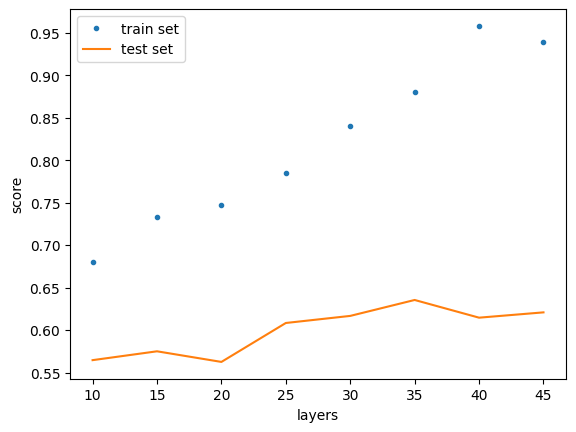

In [7]:
full_df = pd.read_csv(wine_dataset_file, header = 0, delimiter=";")

X = full_df.iloc[:, :-1]
Y = full_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=417)

train_score = []
test_score = []

# more layers does not improve test data
layers = list(range(10,50,5))
for i in layers:
    # scaling / normalizing data helps increase test
    pipe = make_pipeline(StandardScaler(), MLPClassifier(activation = 'logistic',
                                                         solver = 'sgd',
                                                         hidden_layer_sizes = (i,), #tired multiple layers as well, cannot break ~ 0.60 for test
                                                         alpha=1e-2,
                                                         max_iter = 1000,
                                                         learning_rate_init = 0.2))

    pipe.fit(X_train, y_train)
    train_score.append(pipe.score(X_train,y_train))
    test_score.append(pipe.score(X_test, y_test))

plt.plot(layers,train_score,'.',label = 'train set')
plt.plot(layers,test_score,'-',label = 'test set')
plt.xlabel('layers')
plt.ylabel('score')
plt.legend()

optimal_index = test_score.index(max(test_score))
print(f'Best number of hidden nodes: {layers[optimal_index]}, with a test accuracy of {test_score[optimal_index]}')

non_norm = MLPClassifier(activation = 'logistic',
                         solver = 'sgd',
                         hidden_layer_sizes = (layers[optimal_index]), #tired multiple layers as well, cannot break ~ 0.60 for test
                         alpha=1e-2,
                         max_iter = 1000,
                         learning_rate_init = 0.2)

non_norm.fit(X_train, y_train)
print(f'Non normalized test accuracy of {non_norm.score(X_test, y_test)}')